In [1]:
from waterz import agglomerate
import numpy as np

import albumentations as A
import matplotlib.pyplot as plt


import torch
import torchvision.transforms as T
import skimage

from glob import glob
from lsd.train import local_shape_descriptor
from scipy.ndimage import binary_erosion
from skimage.measure import label
from skimage.io import imread, imsave
from torch.utils.data import Dataset

import os

from celldataset_module import CellDataset3D_single
import utils_2D

from scipy import ndimage

/localscratch/conda/envs/lsd-env/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 3d

In [2]:
input_dataset = ' - C=1'
segmentation_dataset = '_CELLS'

train_dataset = CellDataset3D_single(
    image_dir='/group/jug/Enrico/TISSUE_roi/training/*' + input_dataset + '.tif',
    mask_dir='/group/jug/Enrico/TISSUE_roi/training/*' + segmentation_dataset + '.tif',
    crop_size=512,
    input_type='raw', output_type='affinities',
    split='train')




test_iter = iter(train_dataset)

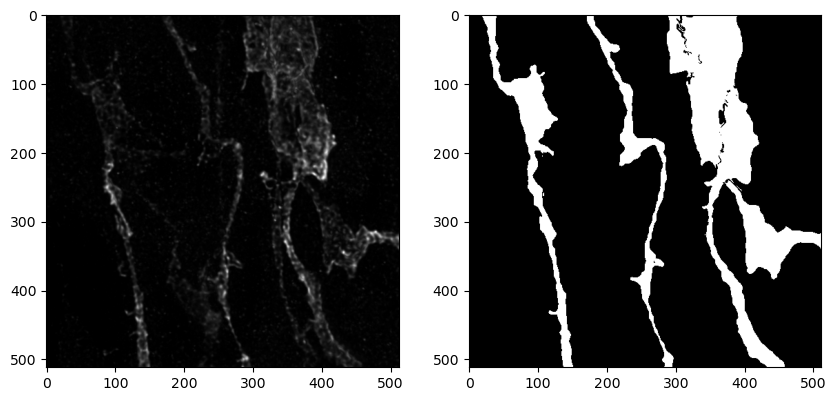

In [ ]:
raw, affinities = next(test_iter)
# affinities is a   [3,depth,height,width] numpy array of float32

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.amax(raw[0], axis=0), cmap='gray')
axes[1].imshow(np.amax(affinities[0], axis=0), cmap='gray')

In [7]:
thresholds = [0.8]

binary_mask = affinities.mean(axis=0) > thresholds[0]  # threshold affinities mean for seed mask
fragments, _ = ndimage.label(binary_mask)
fragments_copy = np.array(fragments, dtype=np.uint64)

for segmentation in agglomerate(affinities, thresholds, fragments=fragments_copy):
    test = segmentation

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 73 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 0
merging until threshold 0.8
computing initial scores
merging until 0.8
merged 0 edges


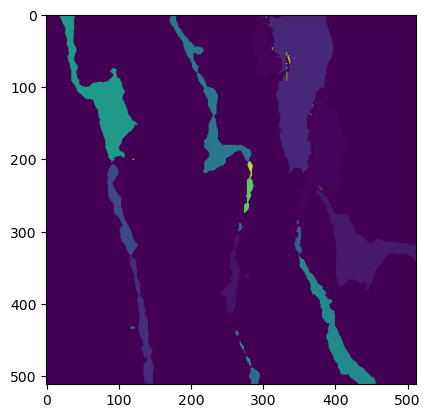

In [8]:

plt.imshow(np.amax(test, axis=0))
plt.show()


# 2d

In [ ]:
input_dataset = '_GFP_max_clahe'
segmentation_dataset = '_CELL_manual'

train_dataset = utils_2D.CellDataset_single(
    image_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + input_dataset + '.tif',
    mask_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + segmentation_dataset + '.tif',
    crop_size=512,
    input_type='raw', output_type='boundaries',
    split='train')


train_iter = iter(train_dataset)

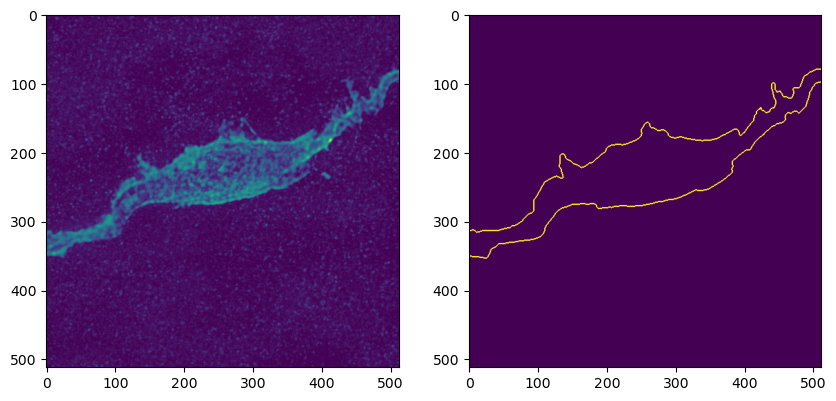

In [3]:
raw, boundaries = next(test_iter)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(raw[0])
axes[1].imshow(boundaries[0])

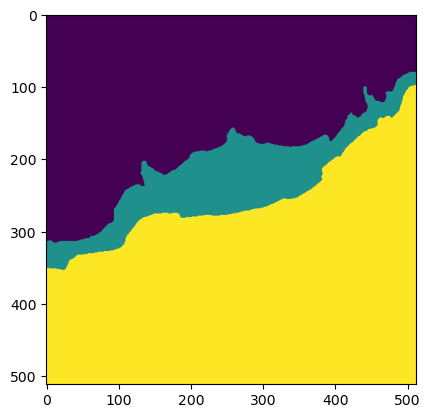

In [4]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
import numpy as np

# Apply watershed
labels = watershed(boundaries[0])

plt.imshow(labels)

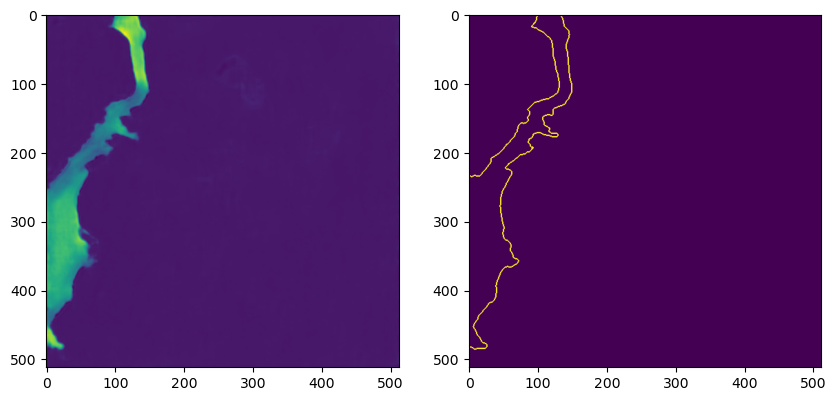

In [23]:
sigma = 10


model_name = '/home/enrico.negri/github/lsd_testing/output/different_sigmas/step10000_b14_c256_lr0.0001_s' + str(sigma) +'/raw-lsds.pth'
model_lsd = utils_2D.model_loader(model_name)

test_dataset = utils_2D.CellDataset_single(
image_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + input_dataset + '.tif',
mask_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + segmentation_dataset + '.tif',
crop_size=512,
split='train',
input_type='lsds', output_type='boundaries',
model=model_lsd,
sigma = 10)

test_iter = iter(test_dataset)

test_in, test_out = next(test_iter)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_in[4])
axes[1].imshow(test_out[0])


In [14]:
image = raw

model_raw_lsd = utils_2D.model_loader('/home/enrico.negri/github/lsd_testing/output/different_sigmas/step10000_b14_c256_lr0.0001_s15/raw-lsds.pth',
                                      n_in = 1,
                                      n_out = 6)
# model_lsd_bou = utils_2D.model_loader('/home/enrico.negri/github/lsd_testing/output/lsd-bound_sigmas/boundaries/step10000_b14_c256_lr0.0001_s15/lsds_pred-boundaries.pth')


print(image)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

activation = torch.nn.Sigmoid()

print(image.shape)
raw_tensor = torch.from_numpy(image.copy())


print(raw_tensor.shape)

logits = model_raw_lsd(raw_tensor)
pred = activation(logits)
pred = pred.cpu().detach().numpy()


# lsd = utils_2D.inference(model_raw_lsd, raw)

[[[0.028 0.028 0.028 ... 0.052 0.028 0.028]
  [0.028 0.028 0.028 ... 0.072 0.028 0.028]
  [0.052 0.004 0.028 ... 0.052 0.028 0.028]
  ...
  [0.028 0.028 0.004 ... 0.028 0.028 0.028]
  [0.028 0.028 0.004 ... 0.028 0.028 0.028]
  [0.028 0.004 0.004 ... 0.052 0.028 0.004]]]
(1, 512, 512)
torch.Size([1, 512, 512])


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor